In [35]:
from torch.utils.tensorboard import SummaryWriter

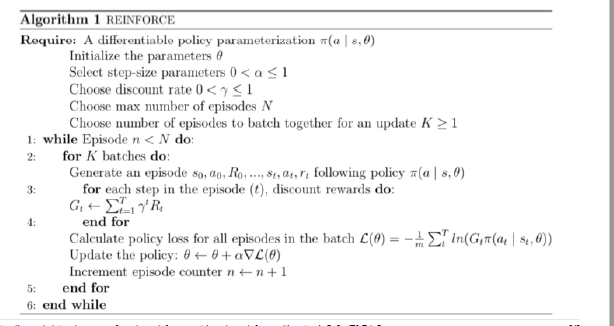

In [1]:
import numpy as np
from machine import Machine
import random
import torch
from torch import nn
import statistics
import matplotlib.pyplot as plt
import pandas as pd

In [2]:


#Parameters
lmd0 = 0.013364
lmd1 = 0.333442
lmdM = 1 - lmd0 - lmd1 #0.6531...
mu0 = 0.125
mu1 = 0.25
muM = 0.5


#transition matrices

#transition matrix for a = 0 (no maintenance)
a0_tm = np.array([[lmdM, lmd1, 0, 0, 0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, lmdM, lmd1, 0, 0, 0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, lmdM, lmd1, 0, 0, 0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, lmdM, 0, 0, 0, 0, lmd1, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], #current state 8 to next state
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]) #current state 9 to next state


#transition matrix for a = 1 (maintenance steps)
a1_tm = np.array([[0, 0, 0, 0, 1-lmd0, 0, 0, 0, 0, lmd0], #current state 0 to next state
                  [0, 0, 0, 0, 0, 1-lmd0, 0, 0, 0, lmd0], #current state 1 to next state
                  [0, 0, 0, 0, 0, 0, 1-lmd0, 0, 0, lmd0], #current state 2 to next state
                  [0, 0, 0, 0, 0, 0, 0, 1-lmd0, 0, lmd0], #current state 3 to next state
                  [muM, 0, 0, 0, 1-muM, 0, 0, 0, 0, 0], #current state 4 to next state
                  [muM, 0, 0, 0, 0, 1-muM, 0, 0, 0, 0], #current state 5 to next state
                  [0, muM, 0, 0, 0, 0, 1-muM, 0, 0, 0], #current state 6 to next state
                  [0, 0, muM, 0, 0, 0, 0, 1-muM, 0, 0], #current state 7 to next state
                  [mu1, 0, 0, 0, 0, 0, 0, 0, 1-mu1, 0], #current state 8 to next state
                  [mu0, 0, 0, 0, 0, 0, 0, 0, 0, 1-mu0]]) #current state 9 to next state



class Machine_env():
    '''
    Description:
    Code creates an environment for the policy to interact with the simulated machine.

    States:
    The simulated machine has 10 states
    [0,1,2,3] are working states that degrades as the state number increases.
    [4,5,6,7] are maintenance states that are transited from [0,1,2,3] respectively if the action deems it need transition
    [8,9] are failure state, where 8 is sudden failure state that can occur from [0,1,2,3] while 9 is a degraded failure from 3

    Actions:
    Type: Discrete(2)
    Num
    0: No maintenance
    1: Maintenance

    Rewards:
    reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}

    Observations:
    Produced using MachineSensor class that uses gmm from pickle file

    Episode:
    Since it is continous Markov model, we shall set 1 episode is 20 steps


    Pseudo code

    initialise class
    Loop 20 times: #1 episode
        sensor()
        action()
        step()

    final otp: Class that contains rewards,actions, observations --> will be used to improve policy (ie. optimise theta)
        
''' 

    def __init__(self,machine):
        self.action_space = [0,1]
        self.state = 0 #Random initialise the start state, assumes uniform distribution for initial state,random.randrange(10)
        self.state_seq = [] #initialise a list that records the actual states
        self.reward_func = {0:1000,1:900,2:800,3:500,4:-500,5:-500,6:-500,7:-500,8:-3000,9:-1000}
        self.observation_space = 4
        self.transition  = [a0_tm,a1_tm]
        self.simulator = machine #simulator to generate sensor readings
        self.done = False
        self.steps = 0
    
    def sensor(self): # generate observation at state
        sensor_reading = self.simulator.readSensors()
        return sensor_reading
    
    def step(self,action): # simulate movement of states given an action
        self.state_seq.append(self.state) #record current state
        transition_mat_action = self.transition[action]
        #print(f"Transition Prob: {transition_mat_action[self.state]}")
        nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based
        reward = self.reward_func[nxt_state] #reward for going to next state
        self.state = nxt_state #update state
        self.simulator.curr_state = self.state #update GMM state
        
        while(self.state in [4,5,6,7]): #cumulative reward during maintenance
            transition_mat_action = self.transition[0] #default action 0 in maintenance state
            nxt_state = np.random.choice([i for i in range(10)],1,p=transition_mat_action[self.state])[0] #select nxt state based on prob
            self.state = nxt_state #update state
            self.simulator.curr_state = self.state #update GMM state
            reward+=self.reward_func[nxt_state]
            
        
        self.steps += 1
        
#         if(self.steps == 50):#condition for end of episode
#             self.done = True
        if self.state in [8,9] or self.steps > 100:
            self.done = True

        return reward
    
    def reset(self):
        self.state = 0
        self.simulator.curr_state = self.state
        self.done = False
        self.steps = 0
        self.state_seq = []
        return 
        
class policy_estimator(): #neural network
    def __init__(self, env):
        self.n_inputs = env.observation_space
        self.n_outputs = len(env.action_space)
        
        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 128), 
            nn.ReLU(), 
            nn.Linear(128, 256),
            nn.ReLU(), 
            nn.Linear(256, self.n_outputs),
        nn.Softmax(dim=-1))
        
    
    def predict(self,observation):#prediction is raw value
        return self.network(torch.FloatTensor(observation))

In [3]:
def entropy(distribution,entropy_coeff):
    entropy = 0
    x = distribution.detach().numpy()
    for row in x:
        entropy += -np.sum(row + np.log(row))

    ave_entropy = entropy/len(x)
    return ave_entropy*entropy_coeff

In [5]:
def discount_rewards(rewards, gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    return r - r.mean()

def normalized_discount_reward(rewards,gamma):
    r = np.array([gamma**i * rewards[i] 
        for i in range(len(rewards))])
    # Reverse the array direction for cumsum and then
    # revert back to the original order
    r = r[::-1].cumsum()[::-1]
    r = np.array(r)
    mean_rewards=np.mean(r)
    std_rewards=np.std(r)
    norm_discounted_rewards=(r-mean_rewards)/(std_rewards+1e-12)
    return norm_discounted_rewards.tolist()

def reinforce(machine,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
     # Set up lists to hold results
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_obs=[]
    batch_actions = []
    ave_reward_store = []
    batch_counter = 1
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.network.parameters(),lr=lr)
    
    action_space = machine.action_space
    ep=0
    while ep < num_episodes:
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while machine.done == False:
            obs = machine.sensor().tolist() #get observation
            
            action_probs = policy_estimator.predict(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            #print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
            
            if machine.done == True:
                batch_rewards.extend(normalized_discount_reward(rewards, gamma))
                batch_obs.extend(observation)
                batch_actions.extend(actions)
                batch_counter+=1
                total_rewards.append(sum(rewards))
                
                if batch_counter == batch_size:
                    discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
                    #update policy
                    obs_tensor = torch.FloatTensor(batch_obs)
                    action_tensor = torch.LongTensor(batch_actions)
                    reward_tensor = torch.from_numpy(np.array(batch_rewards).copy()) #resolve stride problem

                    #Calculate loss Ver 3
                    logprob = torch.log(policy_estimator.predict(obs_tensor))
                    #print(logprob)
                    #print(logprob[np.arange(len(action_tensor)), action_tensor])
                    selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
                    #print(selected_logprobs)
                    
                    loss = -selected_logprobs.mean()

                    
                    optimizer.zero_grad()
                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_obs = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-10:])
                ave_reward_store.append(avg_rewards)
                # Print running average
                print("\rEp: {} Average of last {}: {:.2f}".format(ep+1,batch_size,avg_rewards), end="")
                ep+=1

            #         #Tensorboard params
            #         writer.add_scalar("Loss", loss, ep)
            #         writer.add_scalar('Rewards',sum(rewards),ep)
            #         for name, weight in policy_estimator.network.named_parameters():
            #             try:
            #                 writer.add_histogram(name,weight, ep)
            #             except:
            #                 continue
            #             if weight.grad != None:
            #                 writer.add_histogram(f"{name}.grad",weight.grad, ep)

            #     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
            #     writer.flush()
            #     writer.close()
    
    return (ave_reward_store,total_rewards,state_seq)

# Normal REINFORCE

Ep: 1000 Average of last 10: 22720.00

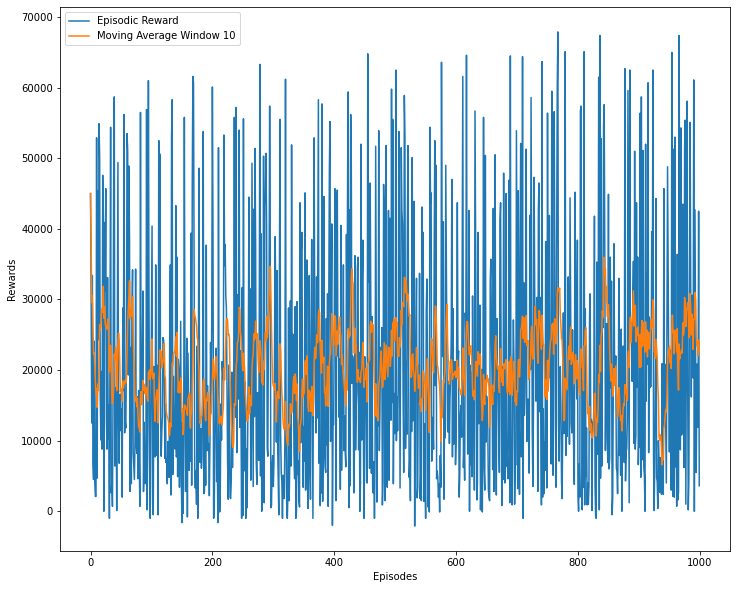

In [6]:
mach = Machine()
mach.curr_state = 0
machine1 = Machine_env(mach)
pol = policy_estimator(machine1)

#Parameters
episodes = 1000
gamma = 0.95
lr = 0.001
batchsize = 10

#writer = SummaryWriter(f"runs/gamma/lr_{lr}gamma_{gamma}episode_{episodes}batch_{batchsize}_mu0_{mu0}_no_entropy_reg")

results = reinforce(machine1,pol,episodes,batchsize,gamma,lr)

ave_rewards = results[0]
rewards = results[1]
episode = [i for i in range(len(ave_rewards))]
fig = plt.figure(figsize=(12,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,ave_rewards,label = f'Moving Average Window 10')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# Entropy Regularised

In [77]:
def reinforce_entropy_regularised(machine,policy_estimator,num_episodes,batch_size,gamma,lr,entropy_coeff): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = [] #Total actual reward for each episode
    batch_rewards = []  #Discounted expected future rewards for each batch
    batch_actions = []
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.network.parameters(),lr=lr)
    
    action_space = machine.action_space
    
    for ep in range(num_episodes):
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while(not machine.done):
            obs = machine.sensor().tolist() #observation
            
            action_probs = policy_estimator.predict(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
        
        discount_r = normalized_discount_reward(rewards,gamma) #normalised already
        
        total_rewards.append(sum(rewards)) #Cumulative reward for this episode
        
        #After batch complete time,store the parameters
        batch_rewards.append(discount_r)
        batch_observation.append(observation)
        batch_actions.append(actions)
        state_seq.append(machine.state_seq)
        
        #update policy
        obs_tensor = torch.FloatTensor(observation)
        action_tensor = torch.LongTensor(actions)
        reward_tensor = torch.from_numpy(np.array(discount_r).copy()) #resolve stride problem


        #Calculate loss Ver 3
        logprob = torch.log(policy_estimator.predict(obs_tensor))
#         print(logprob)
#         print(logprob[np.arange(len(action_tensor)), action_tensor])
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        #print(selected_logprobs)
        
        #Entropy
        prob = policy_estimator.predict(obs_tensor)
        ave_entropy = entropy(prob,entropy_coeff)
        
        loss = -selected_logprobs.mean() - ave_entropy
        
        print(f"Reward for this episode {total_rewards[-1]}, loss is {loss}")
        
        optimizer.zero_grad()
        # Calculate gradients
        loss.backward()
        # Apply gradients
        optimizer.step()
        
#         #Tensorboard params
#         writer.add_scalar("Loss", loss, ep)
#         writer.add_scalar('Rewards',sum(rewards),ep)
#         for name, weight in policy_estimator.network.named_parameters():
#             writer.add_histogram(name,weight, ep)
#             if weight.grad != None:
#                 writer.add_histogram(f"{name}.grad",weight.grad, ep)
    
#     writer.add_graph(policy_estimator.network,torch.FloatTensor(machine.sensor(0))) #draw graph
#     writer.flush()
#     writer.close()
    
    return (total_rewards,batch_actions,state_seq)

C:\Users\overl\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Action prob: [0.4615343 0.5384657], Action: 0, state: 0
Action prob: [0.46223822 0.5377618 ], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 0, state: 4
Action prob: [0.46142536 0.53857464], Action: 0, state: 0
Action prob: [0.4534665 0.5465336], Action: 1, state: 1
Action prob: [0.4150416 0.5849583], Action: 1, state: 5
Action prob: [0.46496356 0.5350364 ], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.4579341 0.5420659], Action: 1, state: 0
Action prob: [0.4150416 0.5849583], Action: 1, state: 4
Action prob: [0.45811212 0.5418878 ], Action: 0, state: 0
Action prob: [0.46233344 0.5376666 ], Action: 0, state: 1
Action prob: [0.46278587 0.5372141 ], Action: 1, state: 2
Action prob: [0.4150416 0.5849583], Action: 1, state: 6
Action prob: [0.46756187 0.5324381 ], Action: 0, state: 1
Action prob: [0.46065444 0.5393455 ], Action: 0, state: 2
Action prob: [0.4666738  0.53332

Action prob: [0.6445046  0.35549536], Action: 1, state: 3
Action prob: [0.5818573  0.41814265], Action: 0, state: 7
Action prob: [0.64440966 0.35559028], Action: 0, state: 2
Action prob: [0.6427652  0.35723475], Action: 1, state: 2
Action prob: [0.5818573  0.41814265], Action: 0, state: 6
Action prob: [0.64219266 0.3578074 ], Action: 1, state: 1
Action prob: [0.5818573  0.41814265], Action: 1, state: 5
Action prob: [0.5818573  0.41814265], Action: 0, state: 5
Action prob: [0.5818573  0.41814265], Action: 1, state: 5
Action prob: [0.5818573  0.41814265], Action: 0, state: 5
Reward for this episode 6100, loss is -0.06303773405224973
Action prob: [0.66949046 0.33050963], Action: 1, state: 0
Action prob: [0.5974966  0.40250337], Action: 1, state: 4
Action prob: [0.5974966  0.40250337], Action: 1, state: 4
Action prob: [0.682806   0.31719398], Action: 0, state: 0
Action prob: [0.6820419  0.31795812], Action: 0, state: 0
Action prob: [0.6741501  0.32584995], Action: 0, state: 0
Action prob: 

Action prob: [0.75518805 0.24481197], Action: 0, state: 2
Action prob: [0.756815   0.24318501], Action: 0, state: 3
Action prob: [0.7260513 0.2739488], Action: 0, state: 8
Action prob: [0.7838412  0.21615882], Action: 1, state: 8
Action prob: [0.7343059  0.26569408], Action: 0, state: 8
Action prob: [0.7314484  0.26855162], Action: 0, state: 8
Action prob: [0.7814168  0.21858324], Action: 0, state: 8
Action prob: [0.78078246 0.21921752], Action: 0, state: 8
Action prob: [0.7835484  0.21645166], Action: 0, state: 8
Action prob: [0.7560559  0.24394406], Action: 0, state: 8
Action prob: [0.730089 0.269911], Action: 1, state: 8
Action prob: [0.7610287  0.23897125], Action: 0, state: 8
Action prob: [0.7580414  0.24195859], Action: 0, state: 8
Action prob: [0.7678102  0.23218979], Action: 0, state: 8
Action prob: [0.75469464 0.24530537], Action: 1, state: 8
Action prob: [0.75763017 0.2423698 ], Action: 1, state: 8
Action prob: [0.7281807 0.2718193], Action: 1, state: 8
Reward for this episod

Action prob: [0.81328875 0.18671131], Action: 0, state: 8
Action prob: [0.8274154  0.17258456], Action: 1, state: 8
Action prob: [0.7840366  0.21596341], Action: 0, state: 8
Action prob: [0.83433896 0.16566111], Action: 0, state: 8
Action prob: [0.7784653  0.22153476], Action: 0, state: 8
Action prob: [0.83423096 0.165769  ], Action: 0, state: 8
Action prob: [0.8220647 0.1779353], Action: 0, state: 8
Action prob: [0.82412845 0.1758716 ], Action: 0, state: 8
Action prob: [0.82136923 0.17863077], Action: 0, state: 8
Action prob: [0.8321917 0.1678083], Action: 0, state: 8
Action prob: [0.83748007 0.16251993], Action: 0, state: 8
Action prob: [0.82203335 0.17796662], Action: 1, state: 8
Action prob: [0.82791305 0.17208694], Action: 0, state: 8
Action prob: [0.8084532  0.19154681], Action: 0, state: 8
Action prob: [0.84374    0.15626003], Action: 0, state: 8
Reward for this episode -91300, loss is 0.02493903779489678
Action prob: [0.8095774  0.19042255], Action: 0, state: 0
Action prob: [0.

Action prob: [0.8547701  0.14522988], Action: 0, state: 9
Action prob: [0.8218496 0.1781504], Action: 0, state: 9
Action prob: [0.8132692  0.18673082], Action: 0, state: 9
Action prob: [0.8663796  0.13362044], Action: 0, state: 9
Action prob: [0.8389516  0.16104838], Action: 0, state: 9
Action prob: [0.86713874 0.1328613 ], Action: 0, state: 9
Action prob: [0.84972256 0.15027747], Action: 0, state: 9
Action prob: [0.82345796 0.17654204], Action: 1, state: 9
Action prob: [0.8591732  0.14082679], Action: 0, state: 9
Action prob: [0.87287825 0.1271217 ], Action: 0, state: 9
Action prob: [0.81832033 0.1816797 ], Action: 0, state: 9
Action prob: [0.8701974  0.12980257], Action: 0, state: 9
Action prob: [0.82144517 0.17855477], Action: 0, state: 9
Action prob: [0.86745095 0.13254903], Action: 1, state: 9
Action prob: [0.85948247 0.14051759], Action: 0, state: 9
Action prob: [0.86568457 0.13431546], Action: 0, state: 9
Action prob: [0.848444   0.15155599], Action: 0, state: 9
Reward for this 

Action prob: [0.80866534 0.19133465], Action: 0, state: 8
Action prob: [0.87551    0.12448999], Action: 0, state: 8
Action prob: [0.8894114  0.11058863], Action: 0, state: 8
Reward for this episode -40700, loss is -0.005236349085091734
Action prob: [0.86859137 0.13140859], Action: 0, state: 0
Action prob: [0.8643074 0.1356926], Action: 0, state: 1
Action prob: [0.86757565 0.13242435], Action: 0, state: 1
Action prob: [0.8680572  0.13194281], Action: 0, state: 2
Action prob: [0.871663   0.12833704], Action: 0, state: 3
Action prob: [0.86571974 0.13428025], Action: 0, state: 3
Action prob: [0.87006354 0.12993649], Action: 0, state: 3
Action prob: [0.8812337  0.11876627], Action: 0, state: 3
Action prob: [0.872927   0.12707298], Action: 0, state: 3
Action prob: [0.8614194  0.13858056], Action: 0, state: 3
Action prob: [0.88841224 0.1115877 ], Action: 0, state: 8
Action prob: [0.8860684 0.1139316], Action: 0, state: 8
Action prob: [0.9078782  0.09212176], Action: 0, state: 8
Action prob: [

Action prob: [0.89614075 0.10385921], Action: 0, state: 8
Action prob: [0.9171392  0.08286078], Action: 0, state: 8
Reward for this episode -86000, loss is -0.0871622815294742
Action prob: [0.88190305 0.11809696], Action: 0, state: 0
Action prob: [0.8850044  0.11499558], Action: 0, state: 0
Action prob: [0.88844794 0.11155207], Action: 1, state: 1
Action prob: [0.48609877 0.51390123], Action: 0, state: 5
Action prob: [0.48609877 0.51390123], Action: 0, state: 5
Action prob: [0.8858865  0.11411349], Action: 0, state: 0
Action prob: [0.8902503  0.10974965], Action: 0, state: 0
Action prob: [0.89312893 0.10687106], Action: 0, state: 1
Action prob: [0.8905277  0.10947227], Action: 0, state: 1
Action prob: [0.8880617  0.11193823], Action: 0, state: 1
Action prob: [0.8893767 0.1106233], Action: 0, state: 1
Action prob: [0.8909081  0.10909192], Action: 0, state: 1
Action prob: [0.88662046 0.11337952], Action: 0, state: 2
Action prob: [0.881099   0.11890095], Action: 0, state: 2
Action prob: [

Action prob: [0.86787766 0.13212231], Action: 0, state: 8
Action prob: [0.9132046  0.08679545], Action: 0, state: 8
Action prob: [0.8789328  0.12106724], Action: 0, state: 8
Action prob: [0.8790019  0.12099811], Action: 0, state: 8
Action prob: [0.9151701 0.0848299], Action: 0, state: 8
Action prob: [0.91563064 0.0843693 ], Action: 0, state: 8
Action prob: [0.91629016 0.08370982], Action: 0, state: 8
Action prob: [0.880076   0.11992406], Action: 0, state: 8
Action prob: [0.8748117  0.12518829], Action: 0, state: 8
Action prob: [0.8779517  0.12204834], Action: 0, state: 8
Action prob: [0.8973716  0.10262842], Action: 0, state: 8
Action prob: [0.8698508  0.13014926], Action: 0, state: 8
Action prob: [0.9154501  0.08454987], Action: 0, state: 8
Action prob: [0.8707391  0.12926088], Action: 0, state: 8
Reward for this episode -58600, loss is -0.003854362623120845
Action prob: [0.90165514 0.09834493], Action: 0, state: 0
Action prob: [0.8996688  0.10033121], Action: 0, state: 0
Action prob:

Action prob: [0.9247096  0.07529039], Action: 0, state: 9
Action prob: [0.8845755  0.11542453], Action: 0, state: 9
Action prob: [0.9387768 0.0612232], Action: 1, state: 9
Action prob: [0.92125934 0.07874063], Action: 0, state: 9
Action prob: [0.9207335  0.07926647], Action: 0, state: 9
Action prob: [0.9284205  0.07157943], Action: 1, state: 9
Reward for this episode -14300, loss is -0.1581989112440043
Action prob: [0.909335   0.09066499], Action: 0, state: 0
Action prob: [0.91446114 0.08553886], Action: 0, state: 0
Action prob: [0.9153806  0.08461948], Action: 0, state: 0
Action prob: [0.91095    0.08904994], Action: 1, state: 0
Action prob: [0.4887372  0.51126283], Action: 1, state: 4
Action prob: [0.9039916  0.09600839], Action: 0, state: 0
Action prob: [0.90492994 0.0950701 ], Action: 0, state: 0
Action prob: [0.91495967 0.08504041], Action: 0, state: 0
Action prob: [0.9059099  0.09409007], Action: 0, state: 1
Action prob: [0.9118841  0.08811588], Action: 0, state: 1
Action prob: [

Action prob: [0.9105639  0.08943616], Action: 0, state: 2
Action prob: [0.91353726 0.08646273], Action: 0, state: 3
Action prob: [0.9319943  0.06800568], Action: 0, state: 3
Action prob: [0.901727   0.09827293], Action: 0, state: 3
Action prob: [0.92405385 0.07594611], Action: 0, state: 3
Action prob: [0.9103141  0.08968589], Action: 0, state: 3
Action prob: [0.9122369  0.08776311], Action: 0, state: 3
Action prob: [0.9048136  0.09518642], Action: 0, state: 3
Action prob: [0.90667933 0.09332065], Action: 0, state: 3
Action prob: [0.9183613  0.08163869], Action: 0, state: 3
Action prob: [0.92867255 0.07132747], Action: 0, state: 3
Action prob: [0.90783495 0.0921651 ], Action: 0, state: 3
Action prob: [0.917068   0.08293205], Action: 0, state: 3
Action prob: [0.89495784 0.10504214], Action: 0, state: 8
Action prob: [0.9283869  0.07161304], Action: 0, state: 8
Action prob: [0.93402576 0.06597419], Action: 0, state: 8
Action prob: [0.9332898  0.06671009], Action: 0, state: 8
Action prob: [

Action prob: [0.8921404  0.10785957], Action: 0, state: 8
Action prob: [0.9394144  0.06058554], Action: 0, state: 8
Action prob: [0.85182834 0.1481716 ], Action: 0, state: 8
Action prob: [0.9381846 0.0618154], Action: 0, state: 8
Action prob: [0.9185148  0.08148524], Action: 0, state: 8
Action prob: [0.9018712  0.09812883], Action: 0, state: 8
Action prob: [0.89978004 0.10022   ], Action: 0, state: 8
Action prob: [0.93125963 0.06874042], Action: 0, state: 8
Action prob: [0.93633986 0.06366016], Action: 0, state: 8
Action prob: [0.93601954 0.06398047], Action: 0, state: 8
Action prob: [0.936122   0.06387801], Action: 0, state: 8
Action prob: [0.92935157 0.07064839], Action: 0, state: 8
Action prob: [0.9477536  0.05224639], Action: 0, state: 8
Action prob: [0.9267985  0.07320153], Action: 0, state: 8
Action prob: [0.9347363 0.0652637], Action: 0, state: 8
Action prob: [0.9264324  0.07356767], Action: 0, state: 8
Action prob: [0.94150054 0.0584995 ], Action: 0, state: 8
Action prob: [0.89

Action prob: [0.92871964 0.0712804 ], Action: 0, state: 8
Action prob: [0.92030865 0.07969136], Action: 0, state: 8
Action prob: [0.9576335  0.04236647], Action: 0, state: 8
Action prob: [0.916034   0.08396598], Action: 1, state: 8
Action prob: [0.9460261  0.05397398], Action: 0, state: 8
Action prob: [0.9106484  0.08935158], Action: 0, state: 8
Action prob: [0.9444816  0.05551835], Action: 0, state: 8
Action prob: [0.93985885 0.06014108], Action: 1, state: 8
Action prob: [0.9572164  0.04278357], Action: 0, state: 8
Action prob: [0.9230258  0.07697425], Action: 0, state: 8
Action prob: [0.9410122 0.0589878], Action: 0, state: 8
Action prob: [0.9120453  0.08795463], Action: 0, state: 8
Action prob: [0.9408439  0.05915614], Action: 0, state: 8
Action prob: [0.9134235  0.08657648], Action: 0, state: 8
Action prob: [0.94593793 0.05406203], Action: 0, state: 8
Action prob: [0.91058373 0.08941624], Action: 0, state: 8
Reward for this episode -29900, loss is -0.08806525791710317
Action prob: 

Action prob: [0.94929236 0.05070769], Action: 0, state: 0
Action prob: [0.93762887 0.06237118], Action: 0, state: 1
Action prob: [0.9419688  0.05803123], Action: 0, state: 1
Action prob: [0.9447099  0.05529018], Action: 0, state: 1
Action prob: [0.93719476 0.06280527], Action: 0, state: 1
Action prob: [0.94946516 0.0505349 ], Action: 0, state: 1
Action prob: [0.942326   0.05767393], Action: 0, state: 1
Action prob: [0.9415444  0.05845558], Action: 0, state: 2
Action prob: [0.940203   0.05979694], Action: 0, state: 3
Action prob: [0.93588537 0.06411461], Action: 0, state: 3
Action prob: [0.95915616 0.04084384], Action: 0, state: 3
Action prob: [0.95239407 0.04760595], Action: 0, state: 8
Action prob: [0.95767075 0.04232923], Action: 0, state: 8
Action prob: [0.95913893 0.04086109], Action: 0, state: 8
Action prob: [0.92535144 0.07464857], Action: 0, state: 8
Action prob: [0.9544241  0.04557586], Action: 0, state: 8
Action prob: [0.95344347 0.04655657], Action: 0, state: 8
Action prob: [

Action prob: [0.9527095  0.04729052], Action: 0, state: 1
Action prob: [0.9559176 0.0440824], Action: 0, state: 2
Action prob: [0.9539493  0.04605076], Action: 0, state: 3
Action prob: [0.9536874  0.04631258], Action: 0, state: 3
Action prob: [0.9527935  0.04720649], Action: 0, state: 3
Action prob: [0.9526872  0.04731284], Action: 0, state: 3
Action prob: [0.93783295 0.06216703], Action: 1, state: 3
Action prob: [0.52502686 0.4749732 ], Action: 0, state: 7
Action prob: [0.9514419  0.04855813], Action: 0, state: 2
Action prob: [0.9528758 0.0471242], Action: 0, state: 2
Action prob: [0.9497753  0.05022476], Action: 0, state: 2
Action prob: [0.9640077  0.03599235], Action: 0, state: 3
Action prob: [0.9534869  0.04651306], Action: 0, state: 3
Action prob: [0.9628963  0.03710374], Action: 0, state: 3
Action prob: [0.96641356 0.03358646], Action: 0, state: 8
Action prob: [0.9631069  0.03689311], Action: 0, state: 8
Action prob: [0.9691574  0.03084258], Action: 0, state: 8
Action prob: [0.93

Action prob: [0.96962804 0.03037201], Action: 0, state: 8
Action prob: [0.9439136  0.05608646], Action: 0, state: 8
Action prob: [0.9446089  0.05539105], Action: 0, state: 8
Action prob: [0.9413497 0.0586503], Action: 0, state: 8
Action prob: [0.9673093  0.03269073], Action: 0, state: 8
Action prob: [0.9427063  0.05729366], Action: 0, state: 8
Action prob: [0.96655387 0.0334461 ], Action: 0, state: 8
Action prob: [0.9727216  0.02727835], Action: 0, state: 8
Action prob: [0.9682151  0.03178493], Action: 0, state: 8
Reward for this episode -111500, loss is -0.17109360281285124
Action prob: [0.95722085 0.0427791 ], Action: 0, state: 0
Action prob: [0.96349305 0.03650695], Action: 0, state: 0
Action prob: [0.958806   0.04119401], Action: 0, state: 0
Action prob: [0.96054417 0.03945588], Action: 0, state: 0
Action prob: [0.95739055 0.04260951], Action: 0, state: 0
Action prob: [0.9611126  0.03888744], Action: 0, state: 0
Action prob: [0.9586193  0.04138075], Action: 0, state: 0
Action prob:

Action prob: [0.97088844 0.02911156], Action: 0, state: 8
Action prob: [0.9707254  0.02927455], Action: 0, state: 8
Action prob: [0.9711421  0.02885794], Action: 0, state: 8
Action prob: [0.95343727 0.04656275], Action: 0, state: 8
Action prob: [0.9536935  0.04630654], Action: 0, state: 8
Action prob: [0.9815059  0.01849413], Action: 0, state: 8
Action prob: [0.9635754  0.03642457], Action: 0, state: 8
Action prob: [0.9762339  0.02376608], Action: 0, state: 8
Action prob: [0.9738733  0.02612662], Action: 0, state: 8
Action prob: [0.9638892 0.0361108], Action: 0, state: 8
Reward for this episode -128300, loss is -0.025173247650255665
Action prob: [0.9634644  0.03653561], Action: 0, state: 0
Action prob: [0.960667   0.03933297], Action: 0, state: 1
Action prob: [0.96073693 0.03926311], Action: 0, state: 2
Action prob: [0.9597595  0.04024046], Action: 0, state: 2
Action prob: [0.9625673  0.03743262], Action: 0, state: 2
Action prob: [0.97045386 0.02954612], Action: 0, state: 3
Action prob

Action prob: [0.95862156 0.04137845], Action: 0, state: 1
Action prob: [0.9605175  0.03948243], Action: 0, state: 1
Action prob: [0.9594582  0.04054181], Action: 0, state: 1
Action prob: [0.9572792  0.04272084], Action: 0, state: 2
Action prob: [0.9362831  0.06371683], Action: 0, state: 3
Action prob: [0.96744746 0.03255256], Action: 0, state: 8
Action prob: [0.94692034 0.05307966], Action: 0, state: 8
Action prob: [0.9428421  0.05715783], Action: 0, state: 8
Action prob: [0.9673708 0.0326292], Action: 0, state: 8
Action prob: [0.94611305 0.05388694], Action: 0, state: 8
Action prob: [0.9714659  0.02853408], Action: 0, state: 8
Action prob: [0.9693443  0.03065563], Action: 0, state: 8
Action prob: [0.9713741  0.02862591], Action: 0, state: 8
Action prob: [0.9470314  0.05296864], Action: 0, state: 8
Action prob: [0.9474498  0.05255013], Action: 0, state: 8
Action prob: [0.9674548  0.03254518], Action: 0, state: 8
Action prob: [0.9401044  0.05989556], Action: 0, state: 8
Action prob: [0.

Action prob: [0.95624036 0.04375966], Action: 0, state: 2
Action prob: [0.95544213 0.04455791], Action: 0, state: 3
Action prob: [0.95927525 0.04072476], Action: 0, state: 3
Action prob: [0.9495686 0.0504314], Action: 0, state: 3
Action prob: [0.95394945 0.04605053], Action: 0, state: 3
Action prob: [0.94017637 0.05982362], Action: 0, state: 3
Action prob: [0.943778   0.05622205], Action: 0, state: 3
Action prob: [0.96624136 0.03375863], Action: 0, state: 3
Action prob: [0.95668495 0.04331505], Action: 0, state: 3
Action prob: [0.9665639  0.03343615], Action: 0, state: 3
Action prob: [0.9356819 0.0643181], Action: 0, state: 3
Action prob: [0.9625636  0.03743637], Action: 0, state: 8
Action prob: [0.9599805  0.04001946], Action: 0, state: 8
Action prob: [0.9755096  0.02449045], Action: 0, state: 8
Action prob: [0.9699421  0.03005791], Action: 0, state: 8
Action prob: [0.9439299  0.05607002], Action: 0, state: 8
Action prob: [0.96467084 0.0353291 ], Action: 0, state: 8
Action prob: [0.96

Action prob: [0.9441804  0.05581952], Action: 0, state: 8
Action prob: [0.96746475 0.03253533], Action: 0, state: 8
Action prob: [0.96173406 0.03826595], Action: 0, state: 8
Action prob: [0.9612493  0.03875074], Action: 0, state: 8
Action prob: [0.9634787  0.03652132], Action: 0, state: 8
Action prob: [0.9312427  0.06875732], Action: 1, state: 8
Reward for this episode -111200, loss is 0.006691933623446139
Action prob: [0.95597667 0.04402339], Action: 0, state: 0
Action prob: [0.9467613  0.05323872], Action: 0, state: 0
Action prob: [0.952012   0.04798798], Action: 0, state: 0
Action prob: [0.94396305 0.05603696], Action: 0, state: 1
Action prob: [0.956053   0.04394697], Action: 0, state: 1
Action prob: [0.9469825  0.05301743], Action: 0, state: 1
Action prob: [0.95008624 0.0499137 ], Action: 0, state: 2
Action prob: [0.94656676 0.05343325], Action: 0, state: 2
Action prob: [0.9383964  0.06160364], Action: 0, state: 3
Action prob: [0.94982433 0.0501757 ], Action: 0, state: 3
Action pro

Action prob: [0.9513713  0.04862872], Action: 0, state: 8
Action prob: [0.90917474 0.09082528], Action: 0, state: 8
Action prob: [0.9432942 0.0567058], Action: 0, state: 8
Action prob: [0.92345136 0.07654863], Action: 0, state: 8
Action prob: [0.9334014  0.06659865], Action: 0, state: 8
Action prob: [0.94103223 0.05896781], Action: 0, state: 8
Action prob: [0.8987029  0.10129708], Action: 0, state: 8
Action prob: [0.94184875 0.05815127], Action: 0, state: 8
Action prob: [0.9384566  0.06154346], Action: 0, state: 8
Action prob: [0.9525022  0.04749781], Action: 0, state: 8
Action prob: [0.94064647 0.0593535 ], Action: 0, state: 8
Action prob: [0.9418773  0.05812264], Action: 0, state: 8
Action prob: [0.90745044 0.09254953], Action: 0, state: 8
Action prob: [0.9443569  0.05564312], Action: 0, state: 8
Action prob: [0.90873146 0.09126861], Action: 0, state: 8
Action prob: [0.95093095 0.04906905], Action: 0, state: 8
Action prob: [0.93797606 0.06202393], Action: 0, state: 8
Action prob: [0.

Action prob: [0.9172341  0.08276588], Action: 0, state: 2
Action prob: [0.91335934 0.08664073], Action: 0, state: 2
Action prob: [0.9133835  0.08661656], Action: 0, state: 3
Action prob: [0.93303365 0.06696635], Action: 0, state: 3
Action prob: [0.9143252  0.08567479], Action: 0, state: 3
Action prob: [0.917286   0.08271401], Action: 0, state: 3
Action prob: [0.9050195  0.09498041], Action: 0, state: 3
Action prob: [0.8823961  0.11760387], Action: 0, state: 8
Action prob: [0.93215173 0.06784828], Action: 0, state: 8
Action prob: [0.9257464  0.07425362], Action: 0, state: 8
Action prob: [0.93175304 0.06824695], Action: 0, state: 8
Action prob: [0.8936274  0.10637267], Action: 0, state: 8
Action prob: [0.88563603 0.11436393], Action: 0, state: 8
Action prob: [0.8913253  0.10867476], Action: 0, state: 8
Action prob: [0.88304913 0.11695087], Action: 0, state: 8
Action prob: [0.92253125 0.07746872], Action: 0, state: 8
Action prob: [0.9288535  0.07114646], Action: 1, state: 8
Action prob: [

Action prob: [0.89865303 0.10134695], Action: 0, state: 1
Action prob: [0.9028893  0.09711076], Action: 0, state: 2
Action prob: [0.8967421 0.1032579], Action: 0, state: 3
Action prob: [0.8995887  0.10041134], Action: 0, state: 3
Action prob: [0.9210895  0.07891053], Action: 0, state: 3
Action prob: [0.92348844 0.0765116 ], Action: 0, state: 8
Action prob: [0.91671455 0.08328552], Action: 0, state: 8
Action prob: [0.8842285  0.11577151], Action: 0, state: 8
Action prob: [0.92676336 0.07323667], Action: 0, state: 8
Action prob: [0.8904661  0.10953395], Action: 0, state: 8
Action prob: [0.8977008  0.10229924], Action: 0, state: 8
Action prob: [0.8961671  0.10383295], Action: 0, state: 8
Action prob: [0.91864294 0.08135712], Action: 0, state: 8
Action prob: [0.8826219 0.1173781], Action: 0, state: 8
Action prob: [0.8988983  0.10110167], Action: 0, state: 8
Action prob: [0.91921854 0.08078147], Action: 0, state: 8
Action prob: [0.9290047  0.07099529], Action: 0, state: 8
Action prob: [0.91

Action prob: [0.90844625 0.09155381], Action: 0, state: 8
Action prob: [0.85210276 0.14789724], Action: 0, state: 8
Action prob: [0.8699594  0.13004054], Action: 0, state: 8
Action prob: [0.85335416 0.14664578], Action: 0, state: 8
Action prob: [0.8525151  0.14748488], Action: 0, state: 8
Action prob: [0.91416216 0.08583787], Action: 0, state: 8
Action prob: [0.88959134 0.11040866], Action: 0, state: 8
Action prob: [0.9063974  0.09360263], Action: 1, state: 8
Action prob: [0.9177624  0.08223756], Action: 0, state: 8
Action prob: [0.86146665 0.13853334], Action: 0, state: 8
Action prob: [0.8545939  0.14540611], Action: 0, state: 8
Action prob: [0.8593829  0.14061707], Action: 0, state: 8
Action prob: [0.85484016 0.14515981], Action: 0, state: 8
Action prob: [0.91191596 0.08808409], Action: 0, state: 8
Action prob: [0.8966308  0.10336917], Action: 0, state: 8
Action prob: [0.9046315  0.09536847], Action: 0, state: 8
Reward for this episode -73500, loss is 0.08113958629506401
Action prob:

Action prob: [0.8342569  0.16574317], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 0, state: 4
Action prob: [0.8323728  0.16762722], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.8227956  0.17720436], Action: 0, state: 0
Action prob: [0.8234804  0.17651962], Action: 1, state: 0
Action prob: [0.54688823 0.45311183], Action: 0, state: 4
Action prob: [0.54688823 0.45311183], Action: 1, state: 4
Action prob: [0.8289602  0.17103982], Action: 0, state: 0
Action prob: [0.82933664 0.17066336], Action: 1, state: 1
Action prob: [0.54688823 0.45311183], Action: 0, state: 5
Action prob: [0.83831805 0.16168192], Action: 0, state: 0
Action prob: [0.8362256  0.16377437], Action: 0, state: 0
Action prob: [0.83145684 0.16854316], Action: 0, state: 1
Action prob: [0.8364826  0.16351742], Action: 0, state: 2
Action prob: [0.8356802 0.1643198], Action: 0, state: 2
Action prob: [0.

<ipython-input-78-d3c55bf3464c>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  actions = np.array(results[1])


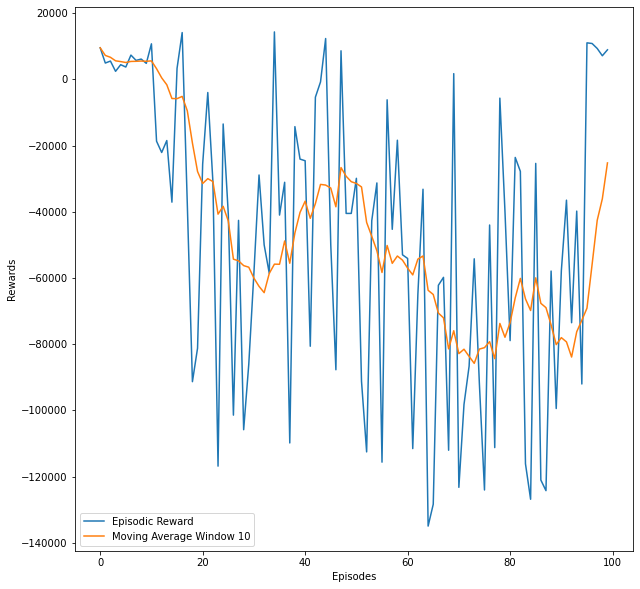

In [78]:
machine1 = Machine_env()
pol = policy_estimator(machine1)

#Parameters
episodes = 100
gamma = 0.8
lr= 0.01
entropy_coeff = 0.01


#writer = SummaryWriter(f"runs/entropy/lr_{lr}gamma_{gamma}episode_{episodes}_mu_{mu0}_entropy_reg_{entropy_coeff}")

results = reinforce_entropy_regularised(machine1,pol,episodes,batchsize,gamma,lr,entropy_coeff)
rewards = results[0]
actions = np.array(results[1])
states = results[2]

episode = [i for i in range(episodes)]

#Moving average we will use a window size of 50

moving_averages = []
window_size = 10

df = pd.DataFrame(rewards,columns = ['r'])
moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

fig = plt.figure(figsize=(10,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

# Baseline Case

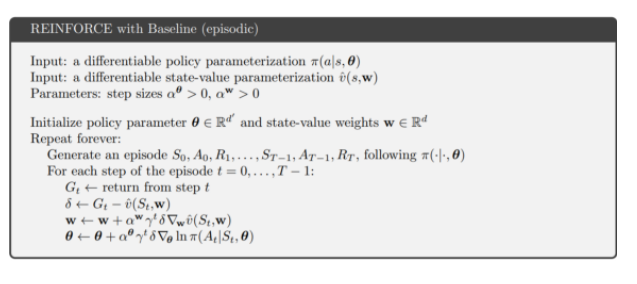

In [13]:
import torch.nn.functional as F

class policy_estimator(nn.Module): #neural network
    def __init__(self, env):
        super(policy_estimator, self).__init__()
        self.n_inputs = env.observation_space
        self.n_outputs = len(env.action_space)
        
        self.layer1 = nn.Linear(env.observation_space,64)
        
        self.layer2 = nn.Linear(64,64)
        self.outlayer = nn.Linear(64,len(env.action_space))
        
            
    
    def forward(self, x):#prediction is raw value
        x = torch.FloatTensor(x)
    
        x = self.layer1(x)
        x  = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.outlayer(x)

        return F.softmax(x,dim = -1)

class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 64)
        self.layer2 = nn.Linear(64,64)
        self.output_layer = nn.Linear(64, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #Nxt layer
        x = self.layer2(x)
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value
    
def train_value(G, state_vals, optimizer):
    ''' Update state-value network parameters
    Args:
    - G (Array): trajectory of cumulative discounted rewards 
    - state_vals (Array): trajectory of predicted state-value at each step
    - optimizer (Pytorch optimizer): optimizer to update state-value network parameters
    '''
    
    G = G.to(torch.float32)
    state_vals = state_vals.to(torch.float32)
    #calculate MSE loss
    val_loss = F.mse_loss(state_vals, G)
        
    #Backpropagate
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()
    

def stack_state_value(states,stateval_network): #input is a list of observations/states that will be used to train the nn for statevalue network
    state_vals = []
    for state in states:
        state = torch.from_numpy(state).float().unsqueeze(0)
        state_vals.append(stateval_network(state))
    return torch.stack(state_vals).squeeze()
    
    
def train_policy(deltas, log_probs, optimizer):
    ''' Update policy parameters
    Args:
    - deltas (Array): difference between predicted stateval and actual stateval (Gt)
    - log_probs (Array): trajectory of log probabilities of action taken
    - optimizer (Pytorch optimizer): optimizer to update policy network parameters
    '''
    
    #store updates
    policy_loss = []
    
    #calculate loss to be backpropagated
    for d, lp in zip(deltas, log_probs):
        #add negative sign since we are performing gradient ascent
        policy_loss.append(-d * lp)
    
    #Backpropagation
    optimizer.zero_grad()
    (sum(policy_loss)/len(policy_loss)).backward()
    optimizer.step()
    
    return sum(policy_loss)
    

In [14]:
def reinforce_baseline(machine,baseline_net,policy_estimator,num_episodes,batch_size,gamma,lr): #Learning algo
    # Set up lists to hold results
    # Set up lists to hold results
    total_rewards = []
    batch_rewards = []
    batch_obs=[]
    batch_actions = []
    ave_reward_store = []
    batch_counter = 1
    batch_observation = []
    state_seq = []
    
    # Define optimizer
    optimizer = torch.optim.Adam(policy_estimator.parameters(),lr=lr)
    state_val_optimizer = torch.optim.Adam(baseline_net.parameters(),lr=0.01)
    
    action_space = machine.action_space
    ep=0
    while ep < num_episodes:
        machine.reset()
        observation = []
        rewards = []
        actions = []
        
        while machine.done == False:
            obs = machine.sensor().tolist() #get observation
            
            action_probs = policy_estimator(obs).detach().numpy() #convert to numpy and get action prob
            action = np.random.choice(action_space, p=action_probs) #select weighted actions based on NN output prob
            #print(f"Action prob: {action_probs}, Action: {action}, state: {machine.state}")
            
            r = machine.step(action) #receive reward and update machine to the next state after doing the sampled action
            
            observation.append(obs)
            rewards.append(r)
            actions.append(action)
            
            if machine.done == True:
                batch_rewards.extend(normalized_discount_reward(rewards, gamma))
                batch_obs.extend(observation)
                batch_actions.extend(actions)
                batch_counter+=1
                total_rewards.append(sum(rewards))
                
                if batch_counter == batch_size:
                    discount_r = normalized_discount_reward(rewards,gamma) #normalised future rewards
                    #update policy
                    obs_tensor = torch.FloatTensor(batch_obs)
                    action_tensor = torch.LongTensor(batch_actions)
                    reward_tensor = torch.from_numpy(np.array(batch_rewards).copy()) #resolve stride problem
                    
                    #calculate state values 
                    state_value_tensor = stack_state_value(np.array(obs_tensor),baseline_net)

                    #train state value network
                    train_value(reward_tensor,state_value_tensor,state_val_optimizer)

                    #print(f"checking {reward_tensor}, {state_value_tensor}")
                    #calculate delta or advantage 
                    try:
                        deltas = [gt - val for gt, val in zip(reward_tensor, state_value_tensor)]
                        deltas = torch.tensor(deltas)
                    except:
                        print("Invalid episode")
                        continue


                    #update policy
                    logprob = torch.log(policy_estimator(obs_tensor))
                    selected_logprobs = logprob[np.arange(len(action_tensor)), action_tensor]
                    loss = train_policy(deltas, selected_logprobs, optimizer)
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_obs = []
                    batch_counter = 1
                    
                avg_rewards = np.mean(total_rewards[-10:])
                ave_reward_store.append(avg_rewards)
                # Print running average
                print("\rEp: {} Average of last {}: {:.2f}".format(ep+1,batch_size,avg_rewards), end="")
                ep+=1

        
    
    return (ave_reward_store,total_rewards,state_seq)

In [15]:
mach2 = Machine()
mach2.curr_state = 0
machine2 = Machine_env(mach2)
#print(machine1.reward_func)
baseline = StateValueNetwork(machine2.observation_space)
pol = policy_estimator(machine2)

#Parameters
episodes = 1000
gamma = 0.95
lr= 0.001
batch_size=10

#writer = SummaryWriter(f"runs/baseline/gamma/lr_{lr}gamma_{gamma}episode_{episodes}_mu_{mu0}")
writer = None
results = reinforce_baseline(machine2,baseline,pol,episodes,batch_size,gamma,lr)
# rewards = results[0]
# actions = np.array(results[1])
# states = results[2]

# episode = [i for i in range(episodes)]

# #Moving average we will use a window size of 50

# moving_averages = []
# window_size = 10

# df = pd.DataFrame(rewards,columns = ['r'])
# moving_ave = df.r.rolling(window_size,min_periods=1).mean().values

# fig = plt.figure(figsize=(10,10))
# plt.title(f'Average Reward vs Episodes: lr_{lr}, gamma_{gamma}')
# plt.plot(episode,rewards,label = 'Episodic Reward')
# plt.plot(episode,moving_ave,label = f'Moving Average Window {window_size}')
# plt.xlabel('Episodes')
# plt.ylabel('Rewards')
# plt.legend()
# plt.show()

Ep: 1000 Average of last 10: 20600.00

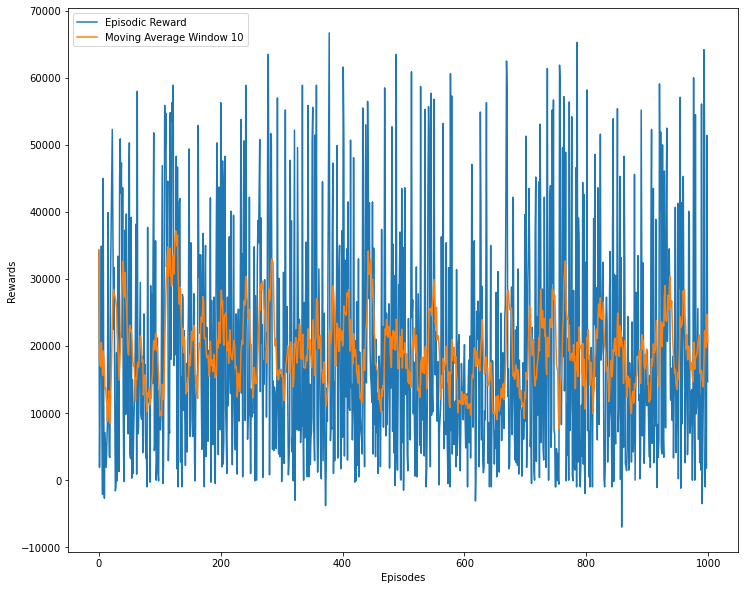

In [16]:
ave_rewards = results[0]
rewards = results[1]
episode = [i for i in range(len(ave_rewards))]
fig = plt.figure(figsize=(12,10))
plt.plot(episode,rewards,label = 'Episodic Reward')
plt.plot(episode,ave_rewards,label = f'Moving Average Window 10')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()